# Explainable AI, Homework 4, Aleksandra Mysiak

# Task 1
Consider the following model:

$f(x_1, x_2) = (x_1 + x_2)^2$

Assume that $ x_1, x_2 \sim U[-1,1]$ and $x_1=x_2$ (full dependency)

Calculate PD profile for variable $x_1$ in this model.

## Solution
In PD, we want to take into account the marginal distribution of $x_2$, that is, $U[-1,1]$, and a fixed value of $x_1$. We thus have

$g_{PD}^1(z) = \mathbb{E}_{x_2 \sim U[-1,1]} f(z, x_2) = \mathbb{E}_{x_2 \sim U[-1,1]} (z + x_2)^2 = \mathbb{E}_{x_2 \sim U[-1,1]} (z^2 + 2x_2 z + x_2^2)$.

Since $z$ is set here, we can write

$g_{PD}^1(z) = z^2 + 2z \mathbb{E}_{x_2 \sim U[-1,1]} x_2 +  \mathbb{E}_{x_2 \sim U[-1,1]} (x_2^2) $

After quick integration of $x$ and $x^2$ over $[-1, 1]$, we have

$ \mathbb{E}_{x_2 \sim U[-1,1]} x_2 = 0$, $ \mathbb{E}_{x_2 \sim U[-1,1]} (x_2^2) = 2/3$

hence

$ g_{PD}^1(z) = z^2 + 2/3 $.

The result is unrealistic, since in reality we have $x_1 = x_2$, and thus if $x_1 = z$, our model will always return $4z^2$.

# Task 2
Ceteris Paribus and Partial Dependence analysis for the [heart disease dataset](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset).

## Sample CP plots
Below, we can see a sample of Ceteris Paribus plots for two data samples -- the ones selected in previous homeworks as interestingly different -- and 4 sample features (in this case, simply the first 4 features in the data).

First of all, we can see that the profiles are at very different levels -- which relates to the fact that the predictions for the two samples are different (0.006 vs 0.993).

Additionally, we can already see that the general shape of the plot does not have to be the same for different samples. We can see both examples of features for which the plots are similar in shape (eg. `trtbps`, `thalachh`), and ones for which they are qualitatively different (`age` and `chol`).

![](cp_sample.png)

## Differing CP plots
Below, we have a selection of 2 features with different profiles, for the same two samples as above.

For `age`, we can see that, for x1, there is almost no change, while for x2 high values of age have a noticeable influence on the prediction. We can guess that for x1, the impact of other features is enough for the model to make up its mind -- patient x1 might have some test results that clearly classify them as a high-risk person. The curve for x2 is more intuitive -- we can see that old age increases the risk of illness, even for otherwise healthy individuals.

For `caa_1`, we can see a much bigger change for x2 than for x1. If we zoom in on the values of CP for x1 (graph below the 2 graphs), we can see that there is a reverse trend than for x2 (although the value change here is neglibile). There is a non-trivial interaction between `caa_1` and some other feature(s); unfortunately, CP does not tell us which ones.

![](cp_sample_diff.png)

![](cp_diff_zoom.png)

## CP and PDP comparison

Below, we have 2 sets of plots for one set of variables: CP for x1 and x2, and PD (which is global).

Overall, we can see that PD profiles tend to be more complicated than singular CP profiles. This might be an effect of including multiple interactions/effects, which cannot all be visible for any single observation.

We can see that the PDP curve for `age` is a bit suspicious, with low overall variability, and a drop in risk around the age of 57. This seems unlikely to be a real effect, and more likely an artifact of averaging.

The PDP curve for `chol` resembles the singular curves for x1 and x2 the most. x2 seems to be representative when it comes to overall impact of this variable -- which cannot be said about x1.

![](cp_sample.png)

![](pdp_samples.png)

## PDP for XGBoost and logistic regression.
Below, we can see PDP plots for our 4 sample variables, for 2 model types.

Overall, we can see that logistic regression is much less elastic. It seems like for these 4 variables, linear regression would be a valid substitute. Nevertheless, the trends for both models seem to be similar, with the largest discrepancy visible for `chol` -- it seems to suggest that logistic regression, in a sense, overfits to data with lower `chol` values, which leads to it returning predictions that are further away from the XGBoost predictions for higher values.

![](pdp_comparison_new.png)

# Appendix

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import xgboost
import dalex as dx

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = "../heart.csv"
CATEGORICAL_COLUMNS = ['sex', 'cp', 'fbs', 'restecg', 'caa', 'exng', 'slp', 'thall']
TARGET_COLUMN = 'output'

## Read in and prepare data

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [5]:
for column in CATEGORICAL_COLUMNS:
    df[column] = df[column].astype(str)

#### Encode categorical features

In [6]:
df = pd.get_dummies(df, drop_first=True)
df.columns

Index(['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'output', 'sex_1',
       'cp_1', 'cp_2', 'cp_3', 'fbs_1', 'restecg_1', 'restecg_2', 'exng_1',
       'slp_1', 'slp_2', 'caa_1', 'caa_2', 'caa_3', 'caa_4', 'thall_1',
       'thall_2', 'thall_3'],
      dtype='object')

#### Select X and y

In [7]:
X = df.drop(columns = [TARGET_COLUMN])

In [8]:
y = df[TARGET_COLUMN]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 0. Train XGBoost

In [10]:
xgboost_model = xgboost.XGBClassifier(
    n_estimators=200, 
    max_depth=4, 
    use_label_encoder=False, 
    eval_metric="logloss"
)

In [11]:
xgboost_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

## 1. Select samples and calculate predictions.

In [12]:
k = 20
x1, y1 = X_test.iloc[0:1], y_test.iloc[0:1]
x2, y2 = X_test.iloc[k:k+1], y_test.iloc[k:k+1]

In [13]:
for x, y in zip((x1, x2), (y1, y2)):
    print(y)
    print(xgboost_model.predict_proba(x))
    print(xgboost_model.predict(x))

179    0
Name: output, dtype: int64
[[0.9927471  0.00725288]]
[0]
267    0
Name: output, dtype: int64
[[0.00563395 0.99436605]]
[1]


## 2. Then, calculate the what-if explanations of these predictions using Ceteris Paribus profiles

In [14]:
def pf_xgboost_classifier_categorical(model, df):
    df.loc[:, df.dtypes == 'object'] =\
        df.select_dtypes(['object'])\
        .apply(lambda x: x.astype('category'))
    return model.predict_proba(df)[:, 1]

explainer = dx.Explainer(xgboost_model, X_test, y_test, predict_function=pf_xgboost_classifier_categorical)

Preparation of a new explainer is initiated

  -> data              : 61 rows 22 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 61 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function pf_xgboost_classifier_categorical at 0x7f9b54884280> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 8.96e-05, mean = 0.622, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.997, mean = -0.081, max = 0.938
  -> model_info        : package xgboost

A new explainer has been created!


In [15]:
X.columns

Index(['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'sex_1', 'cp_1', 'cp_2',
       'cp_3', 'fbs_1', 'restecg_1', 'restecg_2', 'exng_1', 'slp_1', 'slp_2',
       'caa_1', 'caa_2', 'caa_3', 'caa_4', 'thall_1', 'thall_2', 'thall_3'],
      dtype='object')

In [16]:
variables = X.columns[0:4]

Calculating ceteris paribus: 100%|███████████████████████████████████| 22/22 [00:00<00:00, 187.94it/s]


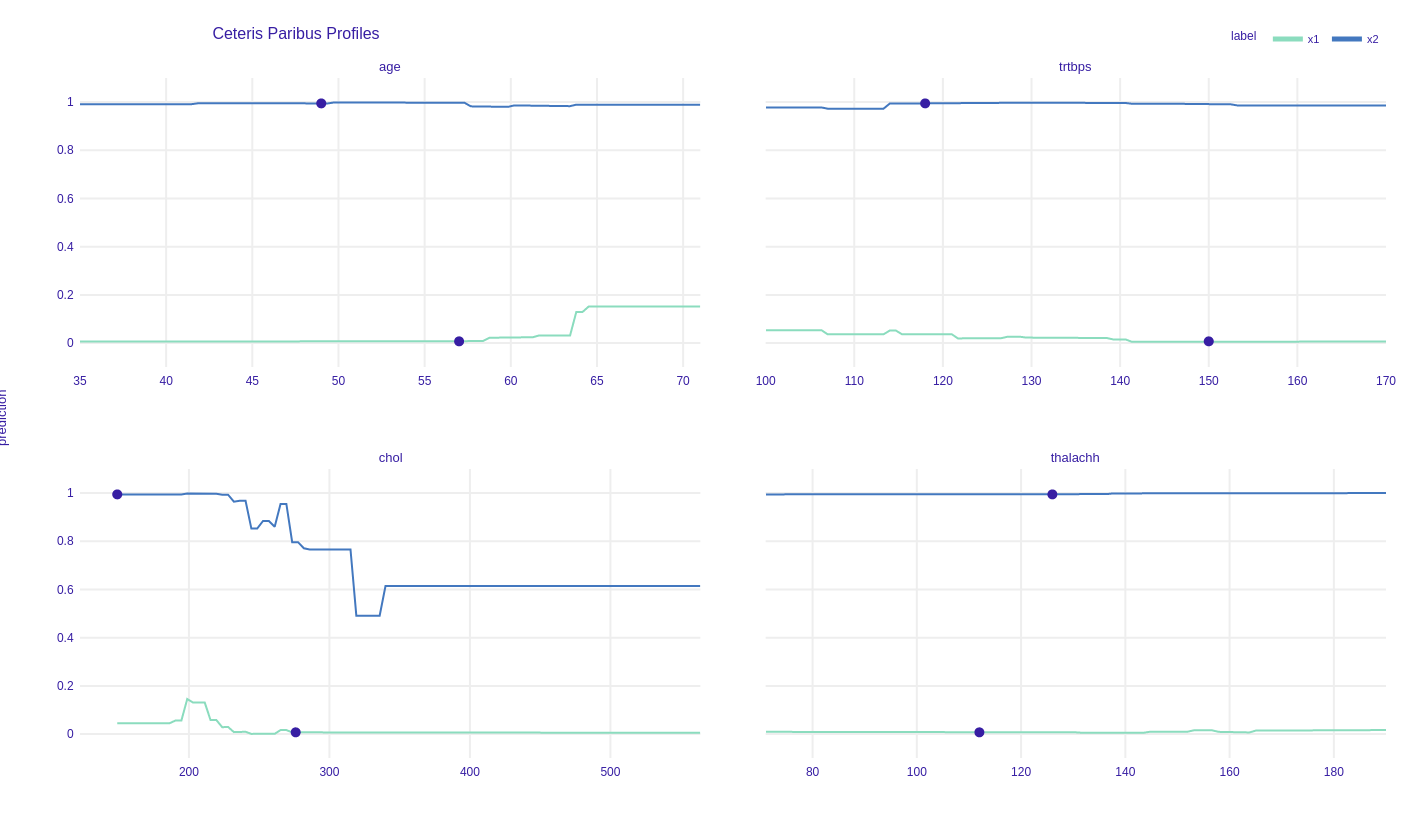

In [30]:
cp1 = explainer.predict_profile(new_observation=x1, label="x1")
cp2 = explainer.predict_profile(new_observation=x2, label="x2")
cp1.plot(cp2, variables=variables)

## 3. Find two observations in the data set, such that they have different CP profiles. 

In [18]:
diff_variables = ["age", "caa_1"]

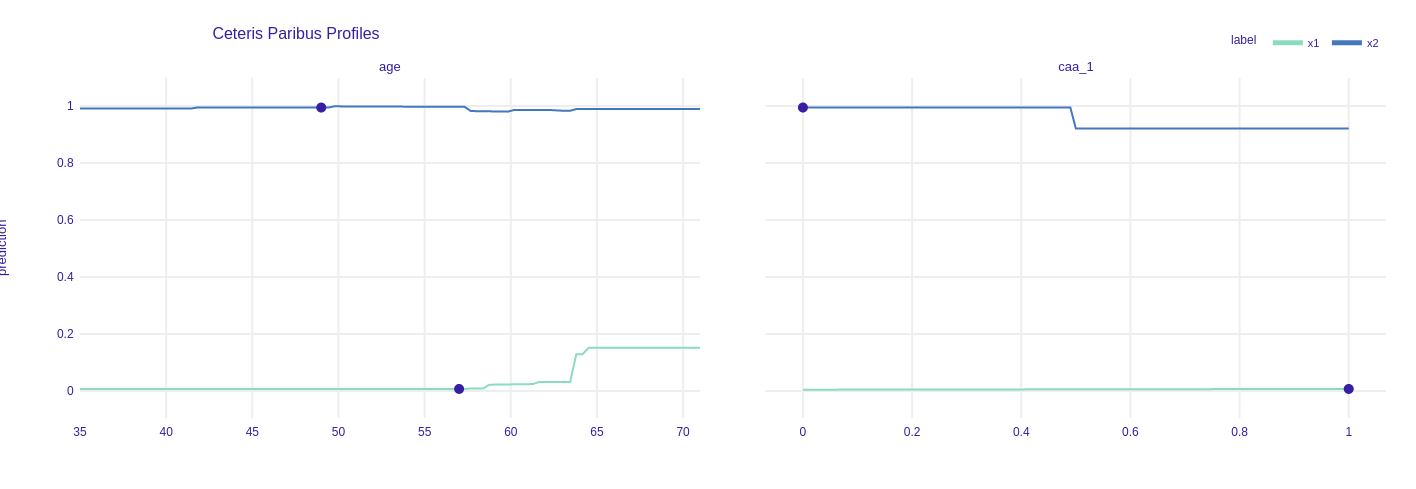

In [29]:
cp1.plot(cp2, variables=diff_variables)

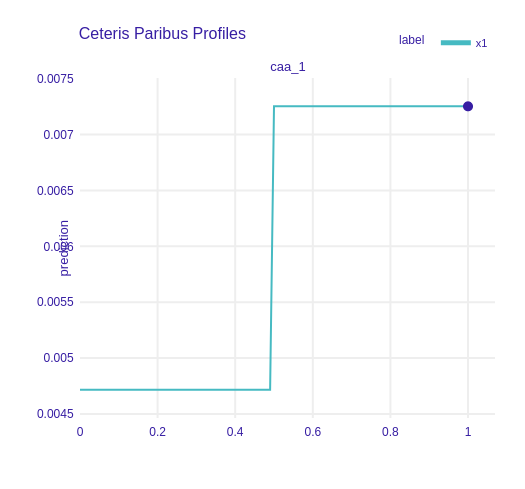

In [19]:
cp1.plot(variables=["caa_1"])

## 4. Compare CP, which is a local explanation, with PDP, which is a global explanation. 

In [21]:
pdp = explainer.model_profile()

Calculating ceteris paribus: 100%|████████████████████████████████████| 22/22 [00:00<00:00, 97.92it/s]


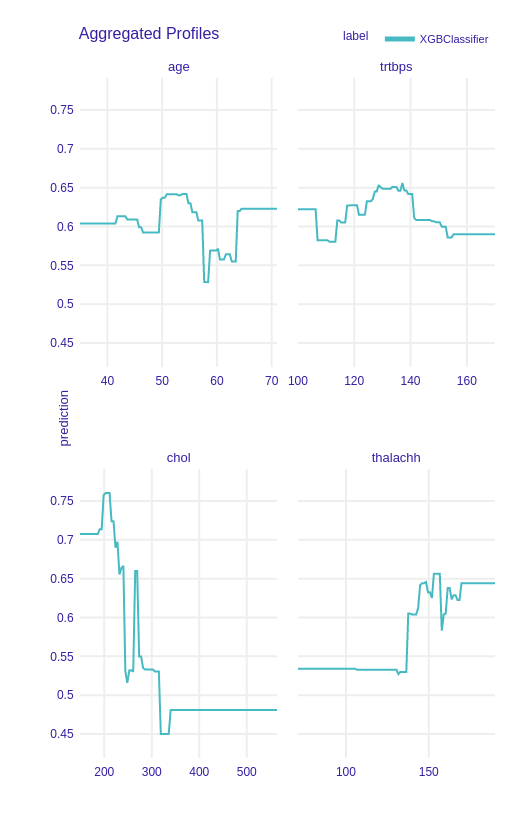

In [22]:
pdp.plot(variables=variables)

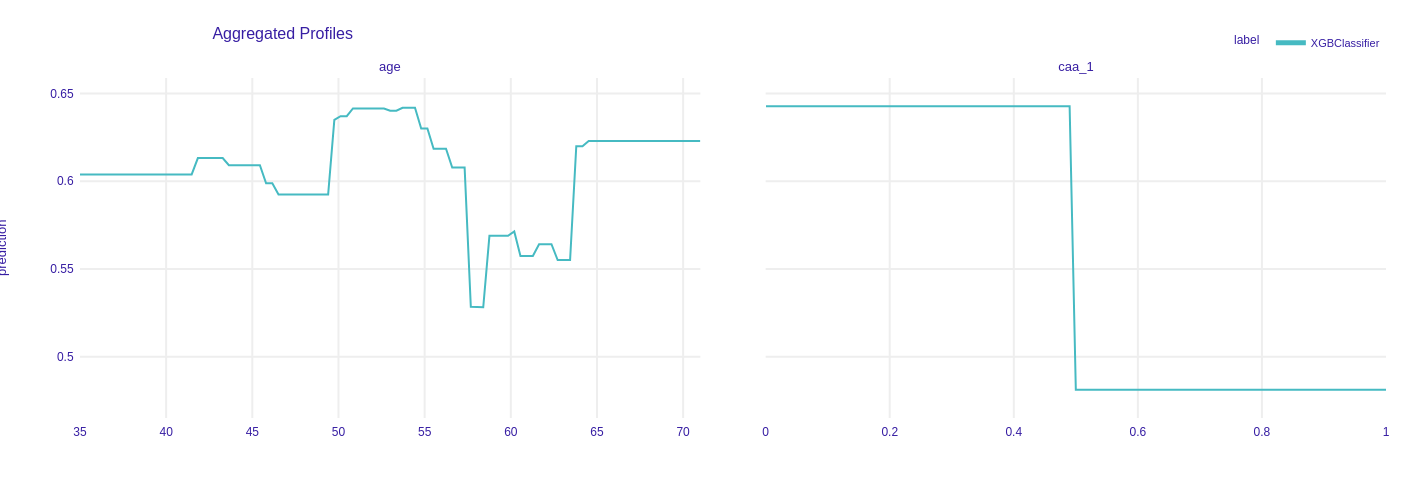

In [31]:
pdp.plot(variables=diff_variables)

## 5. Compare PDP between between at least two different models.

In [23]:
logistic_regression = Pipeline([('scaler', StandardScaler()), ('log', LogisticRegression())])

In [24]:
logistic_regression.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('log', LogisticRegression())])

In [33]:
logistic_explainer = dx.Explainer(logistic_regression, X_test, label="logistic regression", verbose=False)

In [34]:
pdp_log = logistic_explainer.model_profile()

Calculating ceteris paribus: 100%|███████████████████████████████████| 22/22 [00:00<00:00, 153.42it/s]


In [35]:
print(variables)

Index(['age', 'trtbps', 'chol', 'thalachh'], dtype='object')


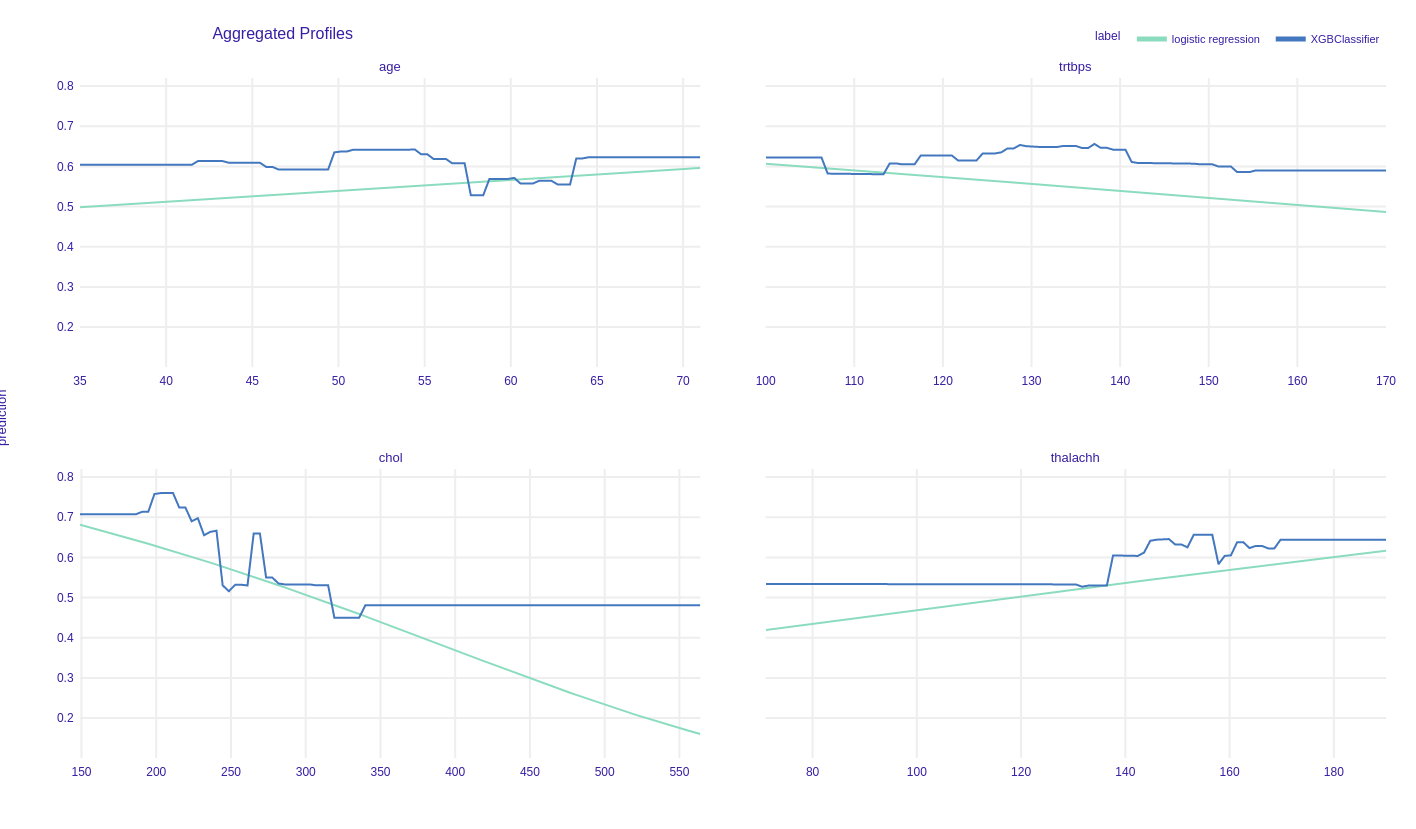

In [36]:
pdp_log.plot(pdp, variables=variables)